<a href="https://colab.research.google.com/github/j-gorzala/PA-projekt/blob/main/PA_projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
import numpy as np

import tarfile
import os

import random
import math

import time
from datetime import timedelta

import PIL.Image
from IPython.display import display
import pickle
import collections

from scipy.stats import itemfreq

from sklearn.metrics import confusion_matrix

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
# https://medium.com/nanonets/how-to-easily-build-a-dog-breed-image-classification-model-2fd214419cde

In [8]:
# Otwieranie pliku images.tar z dysku google
file = tarfile.open("drive/MyDrive/images.tar")

# Ekstrakcja danych
file.extractall('./')
file.close()

In [9]:
min_breed_images_n = 200
train_test_split = 0.7

# Podział zbioru na train i test (odpowiednie słowniki zawierające listy id_zdjęć jako wartości i id_ras jako klucze)
train_dict = {}
test_dict = {}

random.seed(123)
for breed in os.listdir("Images"):
  # Listowanie wszystkich id dla danej rasy
  current_breed_ids = [os.listdir(f"Images/{breed}")][0]
  if len(current_breed_ids) >= min_breed_images_n:
    # Podział na zbiór i test
    current_breed_train_ids = random.sample(current_breed_ids, math.floor(train_test_split * len(current_breed_ids)))
    current_breed_test_ids = [image_id for image_id in current_breed_ids if image_id not in current_breed_train_ids]
    # Przypisanie rasy i id_zdjeć do odpowiedniego słownika
    train_dict[breed] = current_breed_train_ids
    test_dict[breed] = current_breed_test_ids

In [10]:
def list_train_test_paths(train_test):
  if train_test == 'train':
    set_dict = train_dict
  elif train_test == 'test':
    set_dict = test_dict

  set_images_paths = []
  for breed_id, breed_images in set_dict.items():
    for image_id in breed_images:
      current_image_path = f'Images/{breed_id}/{image_id}'
      set_images_paths.append(current_image_path)

  return set_images_paths

print(list_train_test_paths('train'))
print(list_train_test_paths('test'))

['Images/n02110958-pug/n02110958_630.jpg', 'Images/n02110958-pug/n02110958_12781.jpg', 'Images/n02110958-pug/n02110958_11209.jpg', 'Images/n02110958-pug/n02110958_16082.jpg', 'Images/n02110958-pug/n02110958_15615.jpg', 'Images/n02110958-pug/n02110958_15932.jpg', 'Images/n02110958-pug/n02110958_15216.jpg', 'Images/n02110958-pug/n02110958_2041.jpg', 'Images/n02110958-pug/n02110958_14311.jpg', 'Images/n02110958-pug/n02110958_11306.jpg', 'Images/n02110958-pug/n02110958_14154.jpg', 'Images/n02110958-pug/n02110958_10842.jpg', 'Images/n02110958-pug/n02110958_12589.jpg', 'Images/n02110958-pug/n02110958_8814.jpg', 'Images/n02110958-pug/n02110958_12860.jpg', 'Images/n02110958-pug/n02110958_10378.jpg', 'Images/n02110958-pug/n02110958_11675.jpg', 'Images/n02110958-pug/n02110958_12625.jpg', 'Images/n02110958-pug/n02110958_5069.jpg', 'Images/n02110958-pug/n02110958_11458.jpg', 'Images/n02110958-pug/n02110958_15422.jpg', 'Images/n02110958-pug/n02110958_15351.jpg', 'Images/n02110958-pug/n02110958_1227

In [11]:
# This function help to create  a pickle file gathering all the image from a zip folder
def images_to_pickle(train_test, nwidth, nheight):
    # We choose the archive (zip file) + the new width and height for all the image which will be reshaped
    set_list = list_train_test_paths(train_test)
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    # nwidth x nheight = number of features because images have nwidth x nheight pixels
    s = (len(set_list), nwidth, nheight, 3)
    allImage = np.zeros(s)
    i = 0
    images_path = []
    for filename in set_list:
      try:
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwidth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) # 255 = max of the value of a pixel
        allImage[i]=image
        images_path.append(filename)
        i += 1
      except:
        pass
    
    # save the newly created data base
    pickle.dump((allImage, images_path), open(train_test + '.pkl', "wb" ) )
    
    end_time = time.time()
    time_dif = end_time - start_time
    print(f"Total time of the {train_test} set conversion: " + str(timedelta(seconds=int(round(time_dif)))))

In [12]:
# Konwersja zdjęć
image_resize = 120

images_to_pickle(train_test = 'train', nwidth = image_resize, nheight = image_resize)
images_to_pickle(train_test = 'test', nwidth = image_resize, nheight = image_resize)

Total time of the train set conversion: 0:00:18
Total time of the test set conversion: 0:00:09


In [13]:
# load TRAIN
train_tuple = pickle.load(open( "train.pkl", "rb" ))
train = train_tuple[0]
images_path_train = train_tuple[1]
print(train.shape)

# load TEST
test_tuple = pickle.load(open( "test.pkl", "rb" ))
test = test_tuple[0]
images_path_test = test_tuple[1]
print(test.shape)

(2552, 120, 120, 3)
(1102, 120, 120, 3)


## drugi index jest po wierszach, tzn. 80 oznacza y=80 i wszystkie pixele po kolejnych x

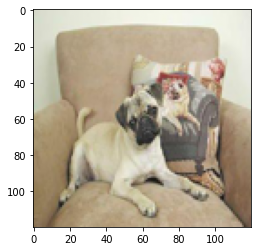

Images/n02110958-pug/n02110958_12781.jpg


In [14]:
# Train set - sprawdzanie po indeksach
i = 1
lum_img = train[i,:,:,:]
plt.imshow(lum_img)
plt.show()
print(images_path_train[i])

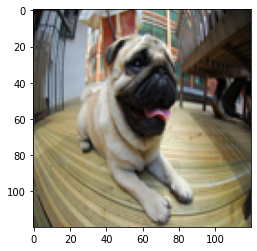

Images/n02110958-pug/n02110958_11870.jpg


In [15]:
# Test set - sprawdzanie po indeksach
i = 1
lum_img = test[i,:,:,:]
plt.imshow(lum_img)
plt.show()
print(images_path_test[i])

In [16]:
train_labels = np.array([breed.split('/')[1].split('-', 1)[1] for breed in images_path_train])
test_labels = np.array([breed.split('/')[1].split('-', 1)[1] for breed in images_path_test])

train_count_df = pd.DataFrame.from_dict(collections.Counter(train_labels), orient='index', columns=['count']).sort_values(['count'], ascending=False)
test_count_df = pd.DataFrame.from_dict(collections.Counter(test_labels), orient='index', columns=['count']).sort_values(['count'], ascending=False)

In [17]:
fig_breeds_train = px.bar(train_count_df, x='count', y=train_count_df.index, orientation='h', title="Liczebność poszczególnych ras dla zbioru treningowego")
fig_breeds_train.show()

In [18]:
fig_breeds_test = px.bar(test_count_df, x='count', y=test_count_df.index, orientation='h', title="Liczebność poszczególnych ras dla zbioru testowego")
fig_breeds_test.show()

## Przekodowanie zmiennej celu

In [19]:
train_labels = train_labels.reshape(train_labels.shape[0], 1)
test_labels = test_labels.reshape(test_labels.shape[0],1)

labels_dict = {label:i for i,label in enumerate(np.unique(test_labels))}
print(labels_dict)

def one_hot_labels(labels, labels_dict):
    bin_labels = []
    n_labels = len(labels_dict)

    for i in range(0, len(labels)):
      breed = labels[i][0]
      breed_index = labels_dict[breed]
      zeros_array = np.zeros(shape=n_labels)
      zeros_array[breed_index] = 1
      bin_labels.append(zeros_array)
    
    return np.array(bin_labels)
  

train_labels_bin = one_hot_labels(train_labels, labels_dict)
test_labels_bin = one_hot_labels(test_labels, labels_dict)
print(train_labels_bin.shape)
print(test_labels_bin.shape)

{'Afghan_hound': 0, 'Airedale': 1, 'Bernese_mountain_dog': 2, 'EntleBucher': 3, 'Great_Pyrenees': 4, 'Irish_wolfhound': 5, 'Leonberg': 6, 'Maltese_dog': 7, 'Pomeranian': 8, 'Saluki': 9, 'Samoyed': 10, 'Scottish_deerhound': 11, 'Sealyham_terrier': 12, 'Shih-Tzu': 13, 'Tibetan_terrier': 14, 'basenji': 15, 'pug': 16}
(2552, 17)
(1102, 17)


# Budowanie sieci

In [20]:
# Our images are 100 pixels in each dimension.
img_size = image_resize

# Number of colour channels for the images: 3
num_channels = 3

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Image Shape
img_shape = (img_size, img_size, num_channels)

# Number of classes : 17 breeds
num_classes = len(labels_dict)

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    #outputs random value from a truncated normal distribution

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
    #outputs the constant value 0.05

In [21]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True,
                   use_dropout=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_conv)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [22]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [23]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,
                 use_dropout=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer, keep_prob_fc)
        
    return layer

In [24]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) #-1 put everything as 1 array
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
keep_prob_fc=tf.placeholder(tf.float32)
keep_prob_conv=tf.placeholder(tf.float32)

In [25]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 32 of these filters.


# Convolutional Layer 2.
filter_size2 = 4          # Convolution filters are 4 x 4 pixels.
num_filters2 = 64      # There are 64 of these filters.


# Convolutional Layer 3.
filter_size3 = 3          # Convolution filters are 3 x 3 pixels.
num_filters3 = 128      # There are 128 of these filters.


# Fully-connected layer.
fc_size = 500 

layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   use_dropout=True)

layer_flat, num_features = flatten_layer(layer_conv3)

#Train
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         use_dropout=True)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False,
                         use_dropout=False)

#Prediction
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [27]:
session = tf.Session()
def init_variables():
   session.run(tf.global_variables_initializer())

In [28]:
batch_size = 50

#function next_batch
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]


    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [29]:
def optimize(num_iterations, X, X_train, y_train, X_test, y_test):
    global total_iterations
    
    start_time = time.time()
    
    #array to plot
    losses = {'train':[], 'validation':[]}
    
    for i in range(num_iterations):
            total_iterations += 1
            # Get a batch of training examples.
            # x_batch now holds a batch of images and
            # y_true_batch are the true labels for those images.
            x_batch, y_true_batch = next_batch(batch_size, X_train, y_train)


            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch,
                               keep_prob_conv : 0.3,
                               keep_prob_fc : 0.4}
            feed_dict_validation = {x: X_test,
                               y_true: y_test,
                               keep_prob_conv : 1,
                               keep_prob_fc : 1}
            
            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)
            
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            acc_validation = session.run(accuracy, feed_dict=feed_dict_validation)
            losses['train'].append(acc_train)
            losses['validation'].append(acc_validation)
            
            # Print status every X iterations.
            if (total_iterations % X == 0) or (i ==(num_iterations -1)):
            # Calculate the accuracy on the training-set.
                                
                msg = "Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}"
                print(msg.format(total_iterations, acc_train, acc_validation))
                
    
    # Ending time.
    end_time = time.time()


    # Difference between start and end-times.
    time_dif = end_time - start_time


    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()

In [1]:
init_variables()
total_iterations = 0
optimize(num_iterations=3500, X=250, X_train=train, y_train=train_labels_bin, X_test=test, y_test=test_labels_bin)

NameError: ignored

In [ ]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 12
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(4, 3, figsize=(14,10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()





def plot_confusion_matrix(data_pred_cls, data_predicted_cls):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
  
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=data_pred_cls,
                          y_pred=data_predicted_cls)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm, cmap='coolwarm')

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

{'Afghan_hound': 0, 'Maltese_dog': 1, 'Scottish_deerhound': 2}


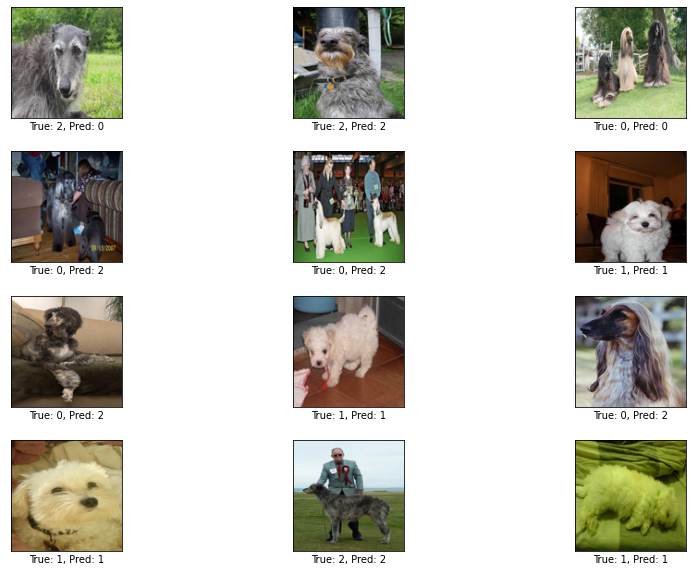

In [ ]:
indices = random.sample(range(0, len(test_labels)), 12)

test_obs_cls = [labels_dict[label[0]] for label in test_labels]
feed_dict_validation = {x: test, y_true: test_labels_bin, keep_prob_conv : 1, keep_prob_fc : 1}
test_pred_cls = session.run(y_pred_cls, feed_dict=feed_dict_validation)

print(labels_dict)
plot_images(images=test[indices], cls_true=list(map(test_obs_cls.__getitem__, indices)), cls_pred=list(map(test_pred_cls.__getitem__, indices)))

[[52  7 13]
 [ 4 67  5]
 [25 12 33]]


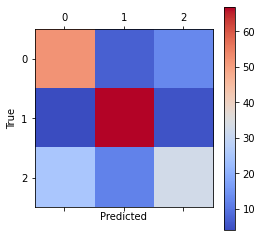

In [ ]:
plot_confusion_matrix(test_obs_cls, test_pred_cls)